# ARMA Models
ARMA: Auto-Regressive Moving Average

## Overview 

In this lecture we will cover:
- The autocorrelation function (ACF).
- The partial autocorrelation function (PACF).
- Explanation of how autoregressive (AR) and moving average (MA) models work.

In [1]:
# Imports
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import ccf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.holtwinters import ExponentialSmoothing
np.random.seed(0) # For reproducibility

In [2]:
def ts_plot(x,y,title,xlabel="Time",ylabel="Value"):
    plt.figure(figsize=(10,5))
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.3);

In [3]:
def acf_pacf_plot(ts,lags=30):    
    fig, ax = plt.subplots(1,2, figsize=(15, 5))
    plot_acf(ts, lags=lags, ax=ax[0])
    plot_pacf(ts, lags=lags, ax=ax[1])
    plt.show()

## Correlations in time series
  - The correlation function measures the degree of association between two random variables.
  - In time series data it measures the association btween two different points in time.
  - Correlation is essential for understanding the linear relationship and dependency in time series data.
  - There are two types of correlation functions: 
      - Autocorrelation.
      - Cross-Correlation.

### Autocorrelation Function (ACF)
  - The ACF measures the correlation of a time series with its own lagged values
  
  $$ ACF(k) = \frac{\mathbb{E}[(X(t) - \mu)(X(t-k) - \mu)]}{\sigma^2} $$ 
  
  - where:
    - $k$ is the lag number.
    - $X(t)$ is the value at time  $t$.
    - $\mu$ is the mean of the series.
    - $\sigma^2$ is the variance of the series.
  - Values close to 1 or -1 indicate strong correlation, while values near 0 indicate weak correlation.

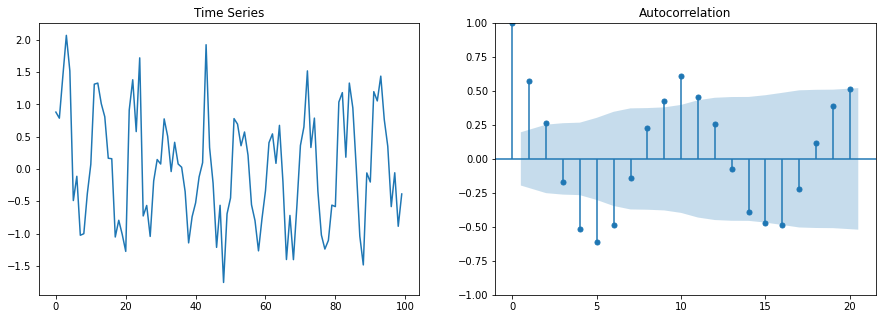

In [4]:
n = 100
ts1 = np.random.normal(0, 0.5, n) + np.sin(2*np.pi/10*np.arange(n))
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(ts1); axs[0].set_title('Time Series')
plot_acf(ts1, lags=20, alpha=0.05, ax=axs[1]);

- The stems represent lagged correlation values. 
- The time series correlates well with itself shifted by 1 (lag 1). 
- A lag of 2 correlates nearly but not quite as well. And so on. 

- The blue region represents a confidence interval. 
- Correlations outside of the confidence interval are statistically significant whereas the others are not. 
- $\alpha$ in this case was 0.05 (95% confidence interval), but it can be set to other levels. 
- See the the [documentation](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html) for more details. 

### Practical Applications of ACF
  - Identifying the nature of the data (e.g., whether it is random, has a trend or a seasonality).
  - Helping to determine the order of ARMA models (more on this later).
<!--   - Identifying outliers in time series data. -->

### Limitations and Considerations
1. Correlation functions only measure *linear* relationships.
2. For meaningful results, time series should be *stationary*.
3. High correlation does not imply *causation* and can sometimes be misleading.
<!-- <img src="media/timoelliot.png" style="width: 25%; display: block; margin: auto;"> -->
<!-- <div style="text-align: center; font-size: 15px;">Image: <a href="https://timoelliott.com/">timoelliot</a></div> -->
4. ACF measures both direct and *indirect correlations* between lags. 
    - A strong correlation at higher lags could be a result of the accumulation of correlations at shorter lags.

### The Partial Autocorrelation Function (PACF)

- PACF addresses the 4th limitation of ACF by isolating the direct correlation between a time series and its lagged version.
- It does that by removing the influence of correlations at shorter lags.
- High PACF at lag $k$ indicates a strong partial correlation with the $k$-th lag, not accounted for by correlations at lower lags.

<!-- - PACF of lag $k$ is sometimes denoted as $\phi_{kk}$: 
$$\phi_{kk} = \text{Corr}\big(X(t) - \hat{X}(t), X(t-k) - \hat{X}(t-k)\big)$$ 
- where:
    - $\hat{X}(t)$ is the predicted value of $X(t)$ based on all the values up to $t-1$.
    - $\hat{X}(t-k)$ is the predicted value of $X(t-k)$ based on all the values up to $t-k-1$. -->

- Using ACF and PACF together provides a more comprehensive understanding of the time series data.
- ACF helps in identifying the overall correlation structure and potential seasonality.
- PACF pinpoints the specific lags that have a significant direct impact on the current value.

**Example**

- Consider a time series where ACF shows significant correlation at lags 1, 2, and 3. 
- Without PACF, it is unclear whether the correlation at lag 3 is direct or merely a reflection of the strong correlations at lags 1 and 2. 
- PACF can clarify this by showing whether there is a significant direct correlation at lag 3.

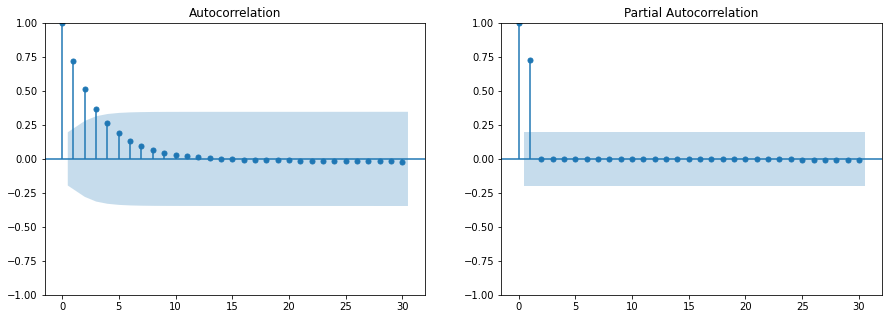

In [59]:
n = 100
X = np.zeros(n)
alpha1, alpha2, alpha3 = 0.7, 0.6, 0.5  # Coefficients for lags 1, 2, and 3
noise = np.random.normal(0, 1, n)

for t in range(3, n):
    X[t] = alpha1 * X[t-1] + alpha2 * X[t-2] + alpha3 * X[t-3] + noise[t]
    
acf_pacf_plot(X)

- Lag estimation with ACF and PACF is helpful in modelling time-series with autoregressive and moving-average models that we'll introduce in the next sections.
  
---

## Autoregressive (AR) models

  - An Autoregressive (AR) model is a type of time series model that uses observations from previous time steps as input to a regression equation to predict the value at the next time step.
  - The AR model is dependent solely on its own past values.
  

- The general form of an AR model of order $p$ is: 

$$X(t) = c + \phi_1 X(t-1) + \phi_2 X(t-2) + \dots + \phi_p X(t-p) + \epsilon_t$$ 

- where
    - $X(t)$: Time series value at time $t$.
    - $c$: Constant term (also known as the intercept).
    - $\phi_1, \phi_2, \dots, \phi_p$: Coefficients of the model.
    - $p$: Order of the AR model (number of lag terms).
    - $\epsilon_t$: Error term (white noise) at time $t$.

**AR(1) Model** 
- The first-frder autoregressive model, AR(1), is 

$$X(t) = c + \phi_1 X(t-1) + \epsilon_t$$

- In an AR(1) model, the current value is based on the immediately preceding value.
> Example: A simple stock price model where today's price is partially dependent on yesterday's price.

**Higher Order AR Models**
- Higher order AR models (AR(2), AR(3), etc.) depend on more than one past value.
- For example, the AR(2) model is: 

$$X(t) = c + \phi_1 X(t-1) + \phi_2 X(t-2) + \epsilon_t$$

- These models are useful in scenarios where the effect of more than one previous time step is significant.

**Estimating AR Model Coefficients**
- Coefficients of AR models can be estimated using various methods like the Maximum Likelihood Estimation (MLE), or Least Squares Estimation (LSE).
- The estimated coefficients provide insights into the influence of past values on the current value in the time series.
- In other words, AR models are **interpretable** (explainable).

**Limitations of AR Models**
- AR models require the time series to be **stationary**.
>- There are extensions (ARIMA, SARIMA) that can deal with trend and seasonality (therefore, do not require stationarity).
- Higher order AR models can **overfit** the training data and perform bad in prediction.
- They cannot model **non-linear** relationships in the data (linear dependence between values).
- AR models do not account for **exogenous factors**.
>- There are usually additional time series that are relevant for the prediction.
>- For example, the time series of the temperatures when predicting the power consumption.
>- There are extensions (ARMAX) that allow exogenous variables in the model.

### AR model identification

- How do we determine the correct order $p$ of the AR model?
- We do that by looking at the first lags of the PACF.
- Let's see it through an example.

- We generate some data from an AR(2) process with coefficients `[1.0, -0.5, 0.7]`.
- Note that the `1.0` at the beginning refers to the zero-lag and is always `1.0`.

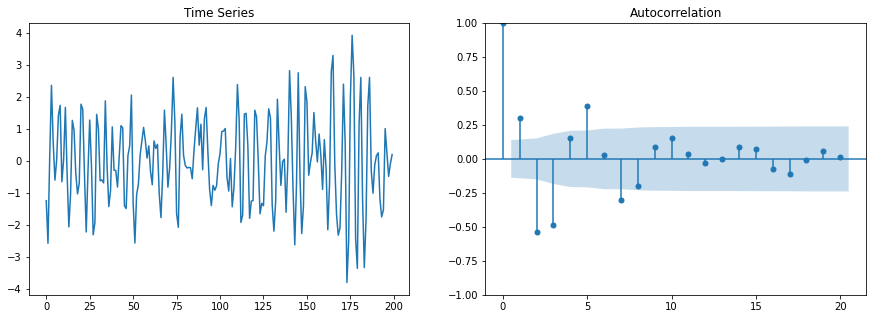

In [80]:
ts_AR = arma_generate_sample(ar=[1.0, -0.5, 0.7], ma=[1], nsample=200, scale=1, burnin=1000)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(ts_AR); axs[0].set_title('Time Series')
plot_acf(ts_AR, lags=20, alpha=0.05, ax=axs[1]);

- Next, we compute the PACF on the `ts_AR`.

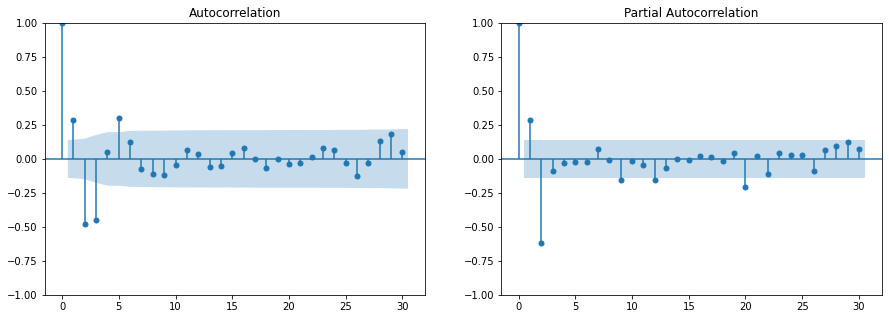

In [78]:
acf_pacf_plot(ts_AR)

- Besides the spike at lag 0, which is always there, we see two significant lags:
    - The *positive* spike at lag 1, introduced by the *negative* coefficient `0.5`.
    - The *negative* spike at lag 2, introduced by the *positive* coefficient `0.7`.

- This means that the process has a *memory* of length 2.
- In other words, (most of) the correlations in the data are explained by the previous 2 time steps.
- If we want to fit an AR model to our data we would choose $p=2$, which is a AR(2) model.

- Finally, an AR process is characterized by correlations that decay slowly in time.
- This can be seen by looking at the ACF plot, where we see significant spikes over many lags.

**⚙ Try it yourself**

- Try modifying/adding/removing values in the `ar` coefficients in `arma_generate_sample`.
- Then, see how the PACF plot changes.

### Forecasting with AR models

- How do we compute forecasts using an AR model?
- In general, our time series has a trend and a seasonality.
- However, an AR model can only be used on **stationary** data.
- Therefore, we need to do the following steps.

#### Step 1: Remove trend and seasonality
- Before applying an AR model is necessary to make the time series stationary.
- This can be done using techniques we saw in the previous chapters.
- Two possibile ways of doing it are:
    1. Apply standard and seasonal differencing to the time series.
<!-- 
    $$
    \begin{aligned}
    R'(t) = X(t + 1) - X(t) & \qquad \text{removes trend} \\
    R(t) = R'(t + L) - R'(t) & \qquad \text{removes seasonality}
    \end{aligned}
    $$ -->

    2. Estimate trend and seasonality (e.g., by using seasonal decomposition or smoothing techniques) and subtract them: 
    
<!--     $$R(t) = X(t) - T(t) - S(t)$$ -->

3. Use ES3 to estimate trend and seasonality

#### Step 2: Apply the AR model

- Identify the order of the AR model.
- Fit an AR model to the detrended and deseasonalized time series.
- Use the model to forecast the values in the forecast period.

#### Step 3: Reconstruct the forecast

- The reconstruction procedure depends on how we made the time series stationary at step 1.
- If we used differencing:
    - We must undo the differentiation by taking cumulative sums of the residuals.
- If we modelled and removed trend and seasonality:
    - Predict the trend and the seasonal component.
    - Add back the estimated trend and seasonality to the forecasted value.

### Example: forecasting with AR model

- Let's generate some data with trend and seasonality.

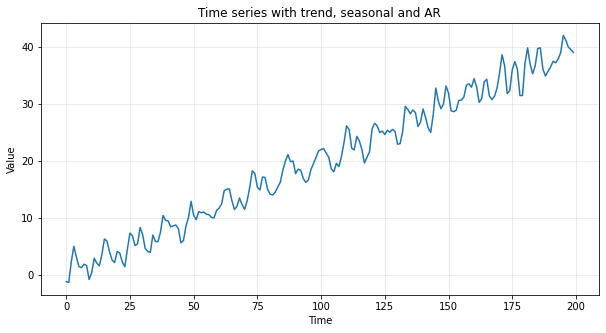

In [81]:
time = np.arange(200)
trend = time * 0.2
seasonality = 2*np.sin(2*np.pi*time/12) # Seasonality 12
ts_trend_seas_AR = trend + seasonality + ts_AR

# _, ax = plt.subplots(1, 1, figsize=(10, 4))
ts_plot(time, ts_trend_seas_AR, "Time series with trend, seasonal and AR");

- Since we are going to compute forecasts, let's divide the data in a train and test set.

In [94]:
train = ts_trend_seas_AR[:164]
test = ts_trend_seas_AR[164:]

- To determine the order $p$ of the AR model we need to look at the PACF.
- The order $p$ corresponds to the least nonzero lag in the PACF plot.

- Both ACF and PACF graphs are meaningful on stationary data.
- If data are stationary, auto-correlations drop quickly in the ACF graph. 
- If they don't, that's a sign that your data is not stationary.

- We generated the time series by hand but we can still test the time series with the ADF to verify it is not stationary. 

In [95]:
tesval, pval, _, _, _, _ = adfuller(train)
print(tesval,pval)

0.7266530099960027 0.9903550393443209


- A p-value that high means we *fail* to reject the null hypothesis

 $$H_0: \text{the data is nonstationary}$$

#### Stationarity through differencing

- We start by applying 1st-order differencing to remove the trend.
- Then, we check the stationarity of the differenced data with the ADF test.

In [105]:
train_diff = np.diff(train)
train_sdiff = train[12:] - train[:-12]

tesval, pval, _, _, _, _ = adfuller(train_sdiff)
print(tesval,pval)

-5.600465033720271 1.2682411622403526e-06


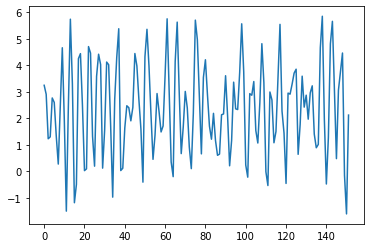

In [100]:
plt.plot(train_sdiff)

- The ADF test suggests that now the time series is stationary.
- We might want to apply also *seasonal differentiation* to get rid of the seasonal component.
- However, differencing too many times might hurt the structure of the data (the problem of *overdifferencing*).

- Let's see how data looks like after 1st-oder differencing.

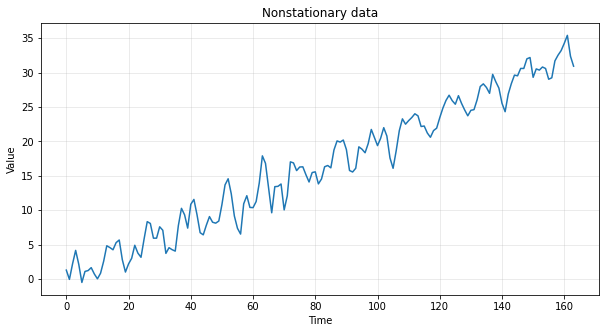

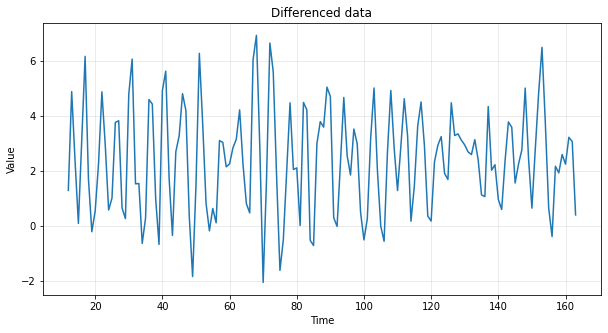

In [12]:
ts_plot(time[:164], train, "Nonstationary data")
ts_plot(time[12:164], train_sdiff, "Differenced data")

- Let's recompute the PACF on the differenced data.
- We also compare it to the PACF on the original `ar_data` and the nonstationary data `train_data_ar`.

In [103]:
train_sdiff.shape

(152,)

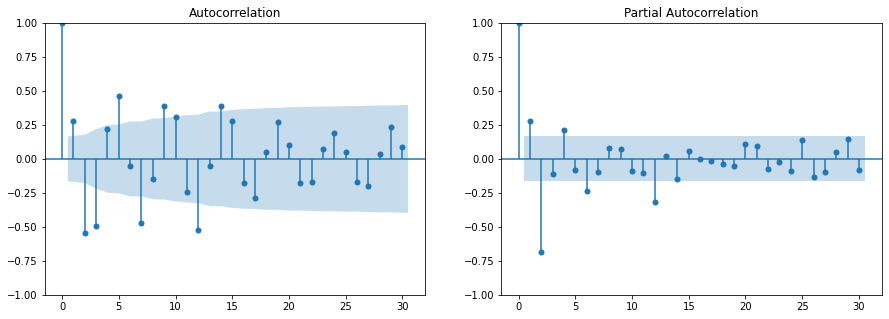

In [107]:
# acf_pacf_plot(ts_AR[:164])
# acf_pacf_plot(train[:164])
acf_pacf_plot(train_sdiff[12:164])

- The PACF of diffrenced data suggests that $p=2$, i.e., we should use an AR(2) model.

**⚠ Attention**

- If we just did first-order differencing, the ADF test could still imply stationarity (despite the seasonality left in the data), but PACF would have a mixed look (spikes at higher lags).
- You can try first-order differencing.

#### Stationarity through Triple Exponential Smoothing (ES3)

- We could estimate the trend and seasonality with Triple Exponential Smoothing (ES3).
- Then, we compute the residuals subtracting the estimated trend and seasonality.
- We expect the residuals to represent our original AR process.

C:\Users\serhan.aydin\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


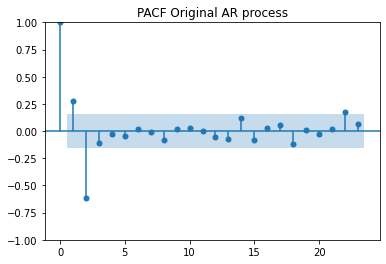

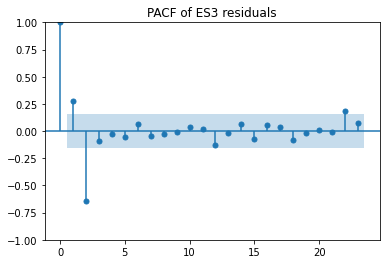

In [17]:
es3 = ExponentialSmoothing(train, trend='additive', seasonal='additive', seasonal_periods=12).fit()
es3_resid = train - es3.fittedvalues

plot_pacf(ts_AR[:164], title="PACF Original AR process");
plot_pacf(es3_resid, title="PACF of ES3 residuals");

**💡 Hint**

- In this case, we knew the main period to be `12`.
- In general, we need to estimate it (for example, using visual check or signal alaysis methods like Fourier analysis).
<!-- - We can use the `fft_analysis` function from Lecture 1. -->

<!-- from tsa_course.lecture1 import fft_analysis

period, _, _ =fft_analysis(time_series_ar)
print(f"Period: {np.round(period)}") -->

<!-- **⚠ Attention**

- Smoothers work so well here because we use toy data with additive components, linear trend, constant variance, etc...
- Many real-world data do not look so nice.
- In some cases, we have to rely on other techniques, including differentiation and the "dirty" ACF/PACF plot we got from it. -->

### Forecasting with AR model

- Once the data are stationary, we are ready to fit the AR(2) model.
- Depending on which method we used to obtain stationary data, we must do something different to reconstruct the predictions.
- Let's start with the stationary data obtained from differencing.

**Differencing approach**

- First, we use `train_sdiff` to fit an AR(2) model and make forecasts for a period as long as the test data.
- Note how after a short while the forecast goes to zero.
- This, indicates that the AR(2) model is very uncertain about long-terms forecasts. 

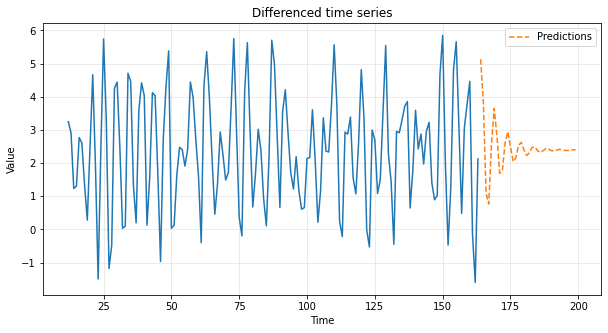

In [108]:
# Fit AR(2) model
model_AR = ARIMA(train_sdiff, order=(2,0,0))
model_AR_fit = model_AR.fit()

# Compute predictions
preds_sdiff = model_AR_fit.forecast(steps=len(test))

ts_plot(time[12:164], train_sdiff, 'Differenced time series')
plt.plot(time[164:], preds_sdiff, label='Predictions', linestyle='--')
plt.legend();

- To obtain the final predictions we must first revert the seasonal differencing.
<!-- and then the 1st-order differencing.  -->

<!-- for t in 
train_preds_sdiff = np.append(train_sdiff, preds_sdiff)
train_preds = train_preds_sdiff[12:] + train_pred_sdiff[:-12]
plt.plot(train_preds) -->

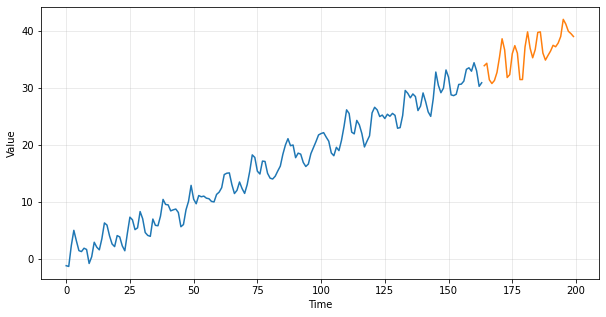

In [109]:
ts_plot(time[:164], train, '')
plt.plot(time[164:], test, label="Test")

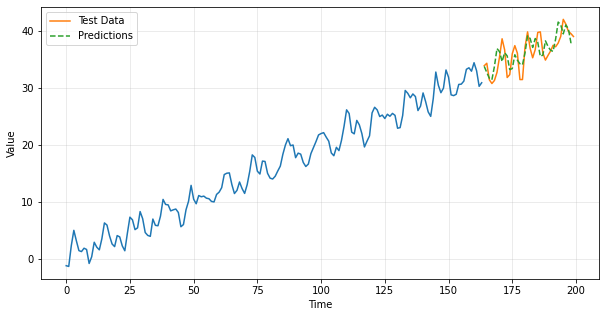

In [111]:
# Reintegrating the seasonal differencing
ts_trend_seas_AR_pred = np.empty(len(test))
ts_trend_seas_AR_pred[:12] = train[-12:] + preds_sdiff[:12]
for i in range(12, len(test)):
    ts_trend_seas_AR_pred[i] = ts_trend_seas_AR_pred[i-12] + preds_sdiff[i]

# Reintegrating 1st order differencing
# reintegrated = reintegrated_seasonal.cumsum() + train_data_ar[-1]

ts_plot(time[:164], train, "")
plt.plot(time[164:], test, label='Test Data')
plt.plot(time[164:], ts_trend_seas_AR_pred, label='Predictions', linestyle='--')
plt.legend();

**⚠ Attention**

- It's very easy to make errors with indices when reverting the differencing operations.
- Also, the previous operations assume that there are no gaps between train and test data.

**ES3-based approach**

- Next, we consider the stationary data obtained by subtracting the trend and seasonality estimated with TES.
- This time we use `tes_resid` to fit the AR(2) model and make forecasts.

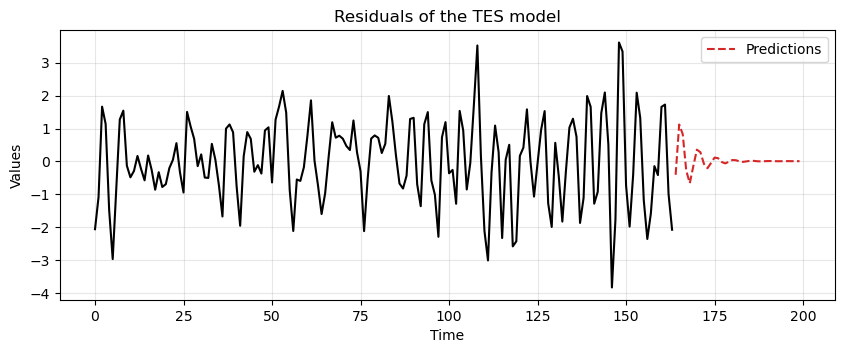

In [48]:
model = ARIMA(tes_resid, order=(2,0,0))
model_fit = model.fit()

resid_preds = model_fit.forecast(steps=len(test_data_ar))

ax = run_sequence_plot(time[:len(train_data_ar)], tes_resid, "")
ax.plot(time[len(train_data_ar):], resid_preds, label='Predictions', linestyle='--', color='tab:red')
plt.title('Residuals of the TES model')
plt.legend();

- Then, we add back the trend and the seasonality to the predictions.
- To do that, we first generate predictions for trend and seasonal components using TES.
- Finally, we sum all the predictions to obtain the final result. 

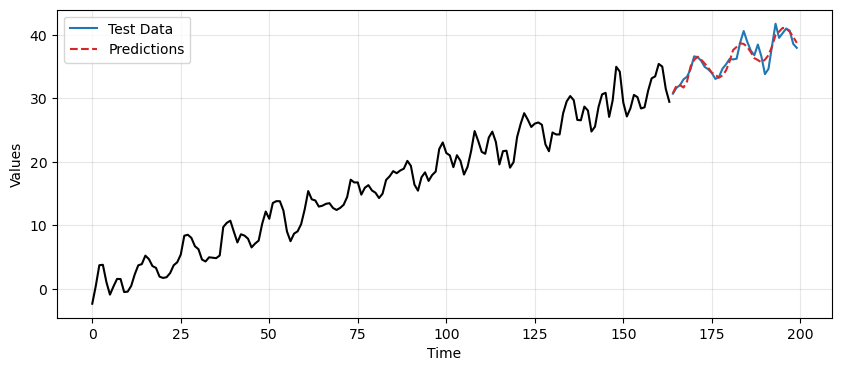

In [49]:
# Add back trend and seasonality to the predictions
tes_pred = tes.forecast(len(test_data_ar))
final_preds = tes_pred + resid_preds

_, ax = plt.subplots(1, 1, figsize=(10, 4))
run_sequence_plot(time[:len(train_data_ar)], train_data_ar, "", ax=ax)
ax.plot(time[len(train_data_ar):], test_data_ar, label='Test Data', color='tab:blue')
ax.plot(time[len(train_data_ar):], final_preds, label='Predictions', linestyle='--', color='tab:red')
plt.legend();

- In this case we obtain better predictions using the TES-based approach compared to differencing.
- We can quantify the difference in performance by computing the MSE.

In [50]:
mse_differencing = mean_squared_error(test_data_ar, reintegrated)
mse_tes = mean_squared_error(test_data_ar, final_preds)

print(f"MSE of differencing: {mse_differencing:.2f}")
print(f"MSE of TES: {mse_tes:.2f}")

MSE of differencing: 7.16
MSE of TES: 1.11


---

## Moving Average (MA) models

- Another approach to modeling univariate time series is the moving average (MA) model.
- The MA model is a linear regression of the current value of the series against the white noise of one or more of the previous values of the series.
- The noise at each point is assumed to come from a normal distribution with mean 0 and constant variance.

- The MA model is defined as 

$$X(t) = \mu + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \dots + \theta_q \epsilon_{t-q}$$ 

- where:
    - $X(t)$: Time series value at time $t$.
    - $\mu$: Mean of the series.
    - $\theta_1, \theta_2, \dots, \theta_q$: Coefficients of the model.
    - $q$: Order of the MA model (number of lagged error terms).
    - $\epsilon_t$: Error term (white noise) at time $t$.

- MA models capture the dependency between an observation and a residual error through a moving average applied to lagged observations.
- Fitting MA estimates is more complicated than AR models because the error terms are not observable.
- Therefore, iterative nonlinear fitting procedures need to be used.
- MA models are less interpretable than AR models.
- As AR models, also MA models require data to be stationary.

**⚠ Attention**
- We talked about smoothing with a moving averages in Lesson 3.
- MA models are not the same as those smoothing techniques.
- Each serves a different, important function.
- We should not confuse the two.

### MA model identification

- Before, for the [AR model identification](#ar-model-identification), we selected $p$ as the lag after which the spikes in the PACF become nonsignificant.
- To identify the order $q$ of the MA model we do the same but we use the ACF plot insted.
- Let's see it through an example.

- We generate some data from an MA(2) process with coefficients `[1.0, 0.7, 0.8]`.
- Again, the `1.0` at the beginning refers to the zero-lag.

In [51]:
ma = np.array([1.0, 0.7, 0.8])  # MA parameters
ma_data = arma_generate_sample(np.array([1]), ma, nsample=len(time), scale=1, burnin=1000) # MA process

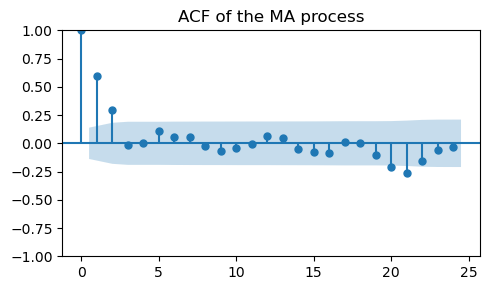

In [52]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_acf(ma_data, ax=ax, title="ACF of the MA process")
plt.tight_layout();

- As expected, there is a cutoff after the second lag.
- This indicates that the order of the MA model is $q=2$

- Characteristic of an MA process are the slowly decaying, alternative spikes in the PACF plot.
- Note how this is complementary to what we saw for the [AR process](#ar-model-identification).

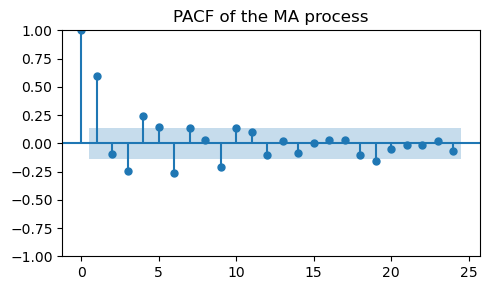

In [53]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_pacf(ma_data, ax=ax, title="PACF of the MA process")
plt.tight_layout();

**⚙ Try it yourself**

- Try modifying/adding/removing values in the `ma` coefficients in `arma_generate_sample`.
- Then, see how the ACF plot changes.

### Example: forecasting with MA model

- We repeat the same procedure as in the [AR example](#example-forecasting-with-ar-model) with a MA model.
- The only difference is that now we construct a time series using a MA process rather than an AR one.

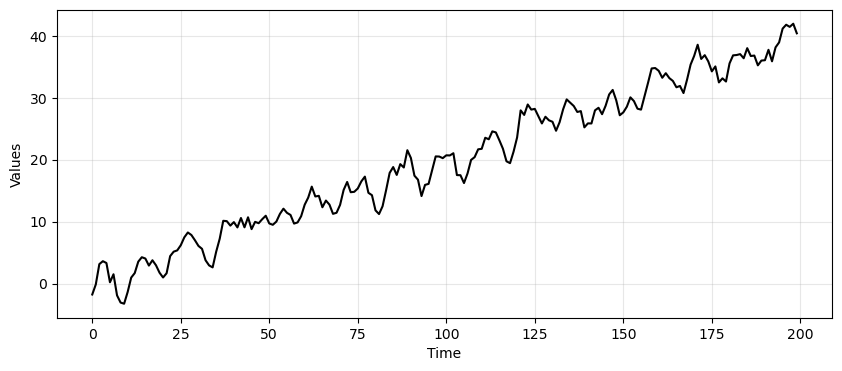

In [54]:
time_series_ma = trend + seasonality + ma_data

_, ax = plt.subplots(1, 1, figsize=(10, 4))
run_sequence_plot(time, time_series_ma, "", ax=ax);

In [55]:
# Train/test split
train_data_ma = time_series_ma[:164]
test_data_ma = time_series_ma[164:]

- To identify the order $q$ of the MA model we must look at the ACF plot.
- Let's start by computing the ACF of `train_data_ma`, which looks very different from the ACF plot we obtained [before](#ma-model-identification) for the MA process.

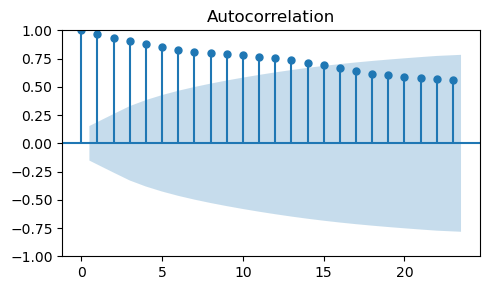

In [56]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_acf(train_data_ma, ax=ax)
plt.tight_layout();

- Also in this case, we need to make the time series stationary to obtain a meaningful ACF plot.
- Like in the AR case, stationarity is needed to correctly estimate the MA coefficients.

#### Stationairty through differencing

- Like we did in the AR example, we will try to obtain stationaity through differencing.


In [57]:
diff_ma = train_data_ma[1:] - train_data_ma[:-1]

- To verify that our data are stationary, we compute the ADF test before and after differentiation.

In [58]:
_, pvalue_ts, _, _, _, _ = adfuller(train_data_ma)
_, pvalue_diff, _, _, _, _ = adfuller(diff_ma)
print(f"p-value (original ts): {pvalue_ts:.3f}")
print(f"p-value (differenced ts): {pvalue_diff:.3f}")

p-value (original ts): 0.925
p-value (differenced ts): 0.000


- We also plot the differenced data and compute the ACF.

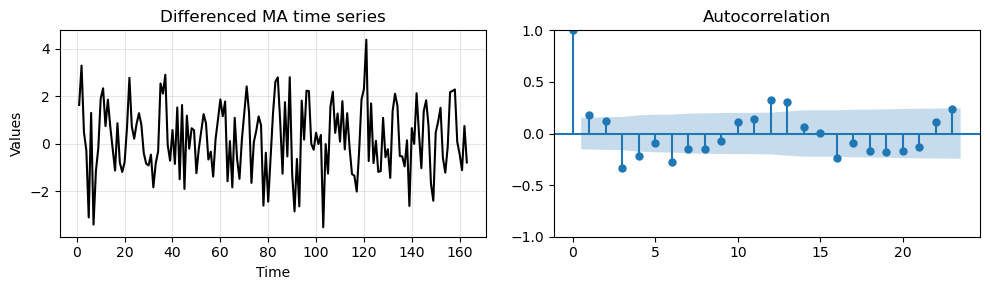

In [59]:
_, axes = plt.subplots(1,2, figsize=(10, 3))
run_sequence_plot(time[1:len(train_data_ma)], diff_ma, "Differenced MA time series", ax=axes[0])
plot_acf(diff_ma, ax=axes[1])
plt.tight_layout();

- Like in the previous case, we have significant correlations at higher lags due to the seasonal component.
- For comparison, we compute the ACF of:
    - the original AR process, 
    - the time series after 1st order differencing,
    - the time series with both 1st order + seasonal differening.

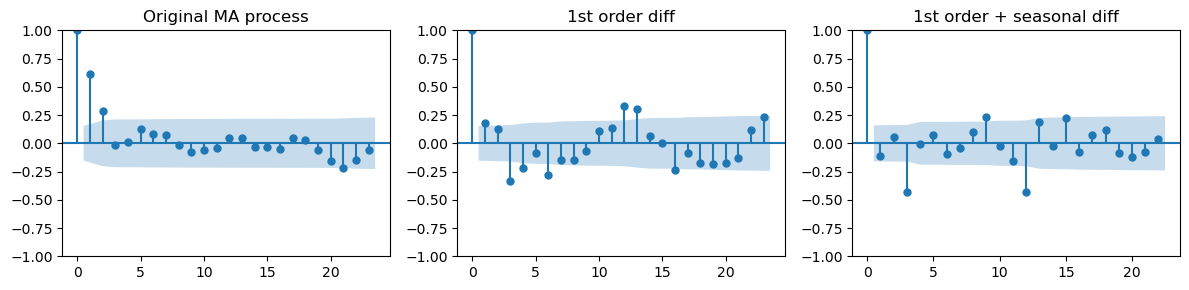

In [60]:
diff_diff_ma = diff_ma[12:] - diff_ma[:-12]

_, axes = plt.subplots(1,3, figsize=(12, 3))
plot_acf(ma_data[:len(train_data_ma)], ax=axes[0], title="Original MA process")
plot_acf(diff_ma, ax=axes[1], title="1st order diff")
plot_acf(diff_diff_ma, ax=axes[2], title="1st order + seasonal diff")
plt.tight_layout();

- When taking both differencing the ACF plot looks very different.
- The positive correlations at lags 1 and 2 are gone and a the first non-zero correlation appears at lag 3.
- Like we saw in the AR case, this hints at an overdifferencing.

- In conclusion, is not obvious which MA model to use from the analysis of the ACF plots.
- The ACF after 1st order differencing suggests using order $p=1$ or $p=2$.
- The ACF obtained after seasonal differencing suggests order $p=3$, but we suspect overdifferencing.

#### Stationarity by subtracting estimated trend and seasonality

- In the following we repeat the same procedure to estimate trend and seasonality with TES.
- Since the MA process is more "noisy" that the AR process, we increase the level of smoothing by setting $\alpha=0.01$.
- As shown in the plot below, this leads to a smoother estimate of the trend and seasonality.

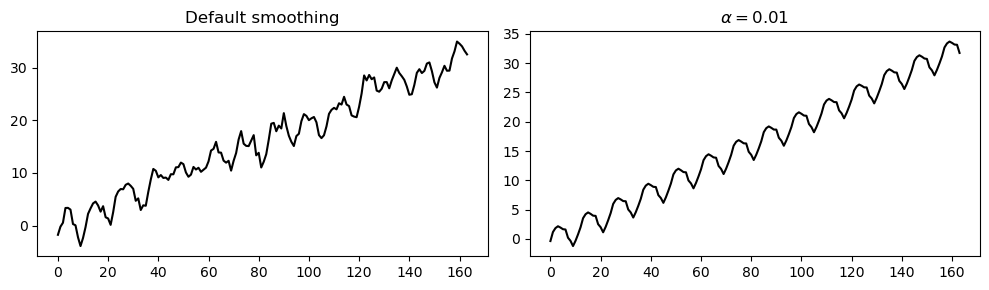

In [61]:
period, _, _ =fft_analysis(time_series_ma) 
period = np.round(period).astype(int)

tes_ma_default = ExponentialSmoothing(train_data_ma, trend='add',
                           seasonal='add', seasonal_periods=period).fit(smoothing_level=None)
tes_ma = ExponentialSmoothing(train_data_ma, trend='add',
                           seasonal='add', seasonal_periods=period).fit(smoothing_level=0.01)
trend_and_seasonality_default = tes_ma_default.fittedvalues 
trend_and_seasonality = tes_ma.fittedvalues 

_, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].plot(trend_and_seasonality_default, 'k')
axes[0].set_title('Default smoothing')
axes[1].plot(trend_and_seasonality, 'k')
axes[1].set_title('$\\alpha=0.01$')
plt.tight_layout();

- Next, we compute the residuals subtracting the estimated trend and seasonality.
- The ACF plots of the original MA process and the residuals are very similar.
- This indicates that we have correctly removed trend and seasonality.

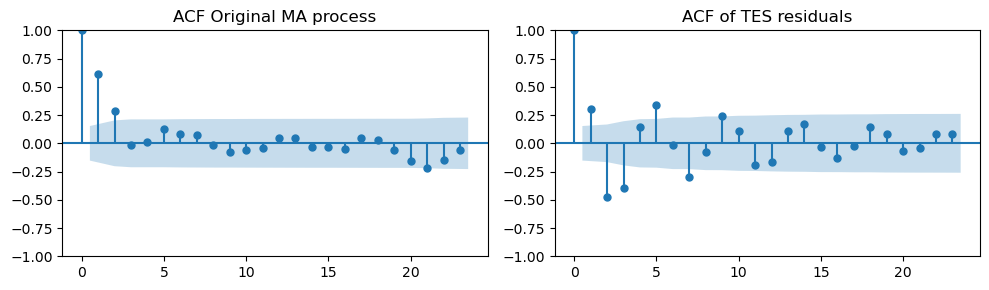

In [62]:
tes_resid_ma = train_data_ma - trend_and_seasonality

_, axes = plt.subplots(1, 2, figsize=(10, 3))
plot_acf(ma_data[:len(train_data_ma)], ax=axes[0], title="ACF Original MA process")
plot_acf(tes_resid, ax=axes[1], title="ACF of TES residuals")
plt.tight_layout();

- The ACF plot shows a significant spike at lag 2.
- This suggests using a MA model with order $q=2$.
- As in the AR case, we compute predictions using both the differencing and the TES-based approach.

**Differencing approach**

- We start by fitting an MA model to `diff_diff_ma` data and compute the predictions.
- Note that, even if we generated the data with an MA(2) process, we use an MA(3) process since the ACF `diff_diff_ma` had a large spike at lag 3.

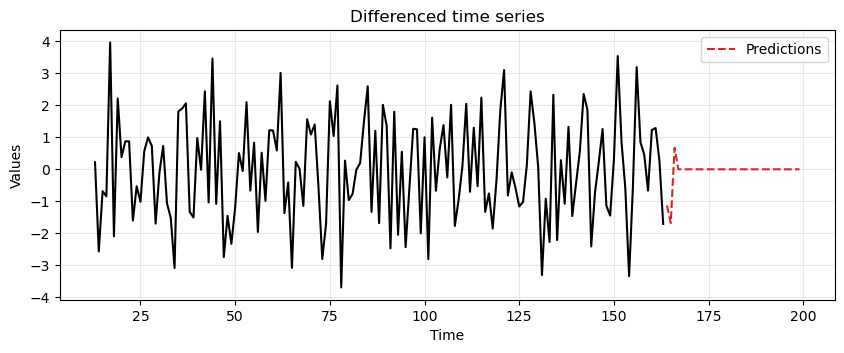

In [63]:
# Fit the model
model = ARIMA(diff_diff_ma, order=(0,0,3))
model_fit = model.fit()

# Compute predictions
diff_preds = model_fit.forecast(steps=len(test_data_ma))

ax = run_sequence_plot(time[13:len(train_data_ma)], diff_diff_ma, "")
ax.plot(time[len(train_data_ma):], diff_preds, label='Predictions', linestyle='--', color='tab:red')
plt.title('Differenced time series')
plt.legend();

- Then, we revert the two differencing operations to obtain the final predictions.

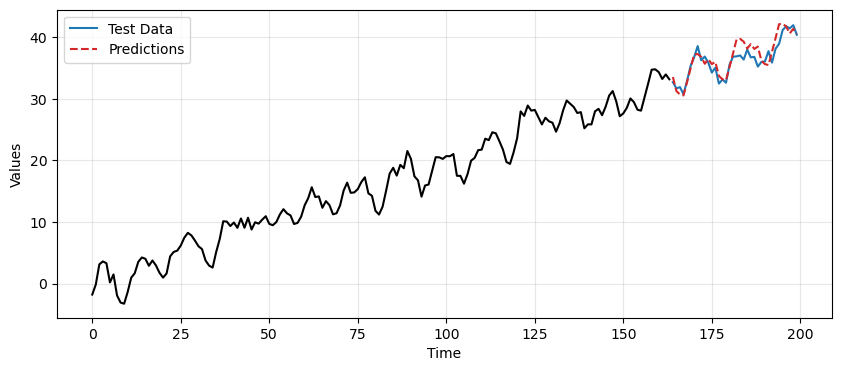

In [64]:
# Reintegrating the seasonal differencing
reintegrated_seasonal = np.zeros(len(test_data_ma))
reintegrated_seasonal[:12] = diff_ma[-12:] + diff_preds[:12]
for i in range(12, len(test_data_ma)):
    reintegrated_seasonal[i] = reintegrated_seasonal[i-12] + diff_preds[i]

# Reintegrating 1st order differencing
reintegrated = reintegrated_seasonal.cumsum() + train_data_ma[-1]

_, ax = plt.subplots(1, 1, figsize=(10, 4))
run_sequence_plot(time[:len(train_data_ma)], train_data_ma, "", ax=ax)
ax.plot(time[len(train_data_ma):], test_data_ma, label='Test Data', color='tab:blue')
ax.plot(time[len(train_data_ma):], reintegrated, label='Predictions', linestyle='--', color='tab:red')
plt.legend();

**TES-based approach**

- This time we fit the MA model with `tes_resid_ma` data and compute the predictions.

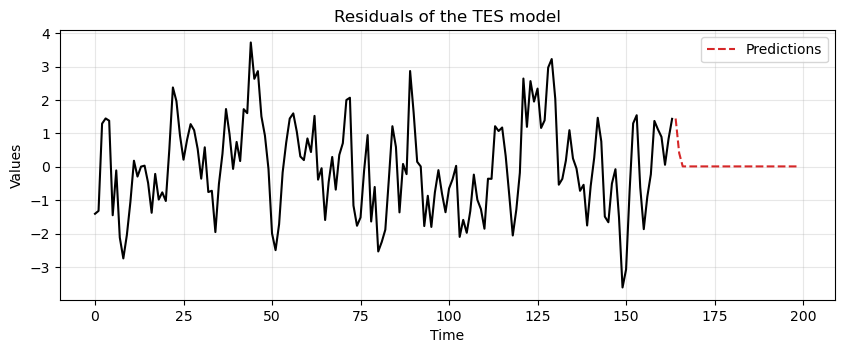

In [65]:
model = ARIMA(tes_resid_ma, order=(0,0,2))
model_fit = model.fit() # Fit the model

resid_preds = model_fit.forecast(steps=len(test_data_ma)) # Compute predictions

ax = run_sequence_plot(time[:len(train_data_ma)], tes_resid_ma, "")
ax.plot(time[len(train_data_ma):], resid_preds, label='Predictions', linestyle='--', color='tab:red')
plt.title('Residuals of the TES model')
plt.legend();

- The final predictions are obtained by combining:
    - the predictions of the residuals from the MA model,
    - the prediction of the trend and seasonality from the TES model.

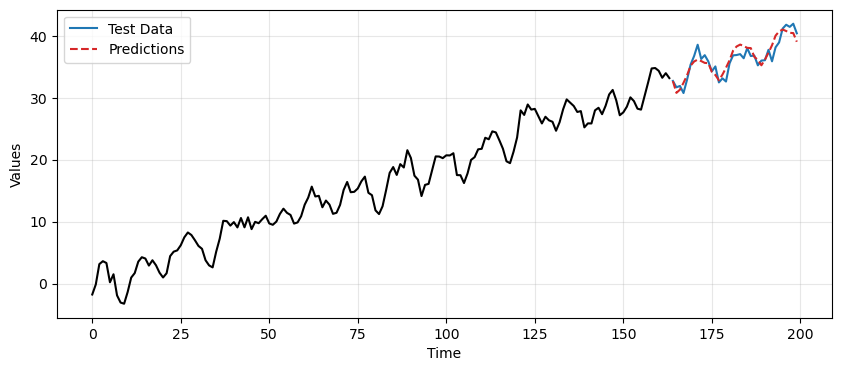

In [66]:
# Add back trend and seasonality to the predictions
tes_pred = tes_ma.forecast(len(test_data_ma))
final_preds = tes_pred + resid_preds

_, ax = plt.subplots(1, 1, figsize=(10, 4))
run_sequence_plot(time[:len(train_data_ma)], train_data_ma, "", ax=ax)
ax.plot(time[len(train_data_ma):], test_data_ma, label='Test Data', color='tab:blue')
ax.plot(time[len(train_data_ma):], final_preds, label='Predictions', linestyle='--', color='tab:red')
plt.legend();

- This time the differencing approach gives better results but still worse than the TES-based approach.

In [67]:
mse_differencing = mean_squared_error(test_data_ma, reintegrated)
mse_tes = mean_squared_error(test_data_ma, final_preds)

print(f"MSE of differencing: {mse_differencing:.2f}")
print(f"MSE of TES: {mse_tes:.2f}")

MSE of differencing: 2.09
MSE of TES: 1.44


---

## Summary

### AR vs MA Models

| **AR Models** | **MA Models** |
|:--------------|:--------------|
|Depend on past values of the series. | Depend on past forecast errors. |
| Suitable when past values have a direct influence on future values and for slowly changing time series | Useful when the series is better explained by shocks or random disturbances, i.e., time series with sudden changes|
| If the **PACF** drops sharply at a given lag $p$ or the first lag autocorrelation is **positive**, then use an **AR** model with order $p$| If the **ACF** drops sharply at a given lag $q$ or the first lag autocorrelation is **negative**, then use an **MA** model with order $q$ |

In this lecture you should have learned the basics of: 

1. The Autocorrelation Function (ACF).
2. The Partial Autocorrelation Function (PACF).
3. Autoregressive (AR) models.
4. Choosing order $q$.
5. Moving Average (MA) models.
6. Choosing order $p$. 
7. Combining smoothers to predict trend and seasonality with AR/MA models to predict the resuals.

---

## Exercises

- Load the two time series `arma_ts1` and `arma_ts2` by running the code below.

In [68]:
# Load the first time series
response = requests.get("https://zenodo.org/records/10951538/files/arma_ts3.npz?download=1")
response.raise_for_status()
arma_ts1 = np.load(BytesIO(response.content))['signal']
print(len(arma_ts1))

# Load the second time series
response = requests.get("https://zenodo.org/records/10951538/files/arma_ts4.npz?download=1")
response.raise_for_status()
arma_ts2 = np.load(BytesIO(response.content))['signal']
print(len(arma_ts2))

479
1000


For each time series

1. Split the time series in train and test.
    - Use the last 30 values as test for the first time series 
    - Use the last 100 as test for the second time series.
2. Make the time series stationary.
3. Determine the order $p$ of an AR model.
4. Compute the prediction of the test data with the AR($p$) model.
5. Determine the order $q$ of a MA model.
6. Compute the prediction of the test data with the MA($q$) model.